In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode()
from plotly import graph_objs as go

In [54]:
cd ~/PycharmProjects/defense_spending/data/

/Users/chris/PycharmProjects/defense_spending/data


# Scraping data from the US DoD contract website
I wrote a quick and dirty web scraper last night to scrape contract data from the [US Department of Defense contracts website](https://www.defense.gov/News/Contracts/). The idea is to geocode this data, and follow it over time. 

The dataset sits at just over 300 MB in size. Over 55,000 contracts are included in the dataset.


### Project intent:
* Will there be interesting spatiotemporal patterns that will tell us something about the political climate where these contracts were awarded?
* Can we make a predictor for where contracts are likely to be awarded based on previous and upcoming election data?
* It would be interesting to do concept modeling of the contract information (ie, weapons vs healthcare, intelligence, research, etc.)

### Testing the scraper and looking at basic representations of the data
The data is accessible and all data from 2014 is really standardized. The data going back to 1995 is there, but the formatting is quite noisy and my scraper _still needs some work_, but let's take a look at what we've got so far.

In [55]:
data = pd.read_csv('dataset_1.csv', parse_dates=True, index_col=0)
data2 = data[data.amount > 1e6]

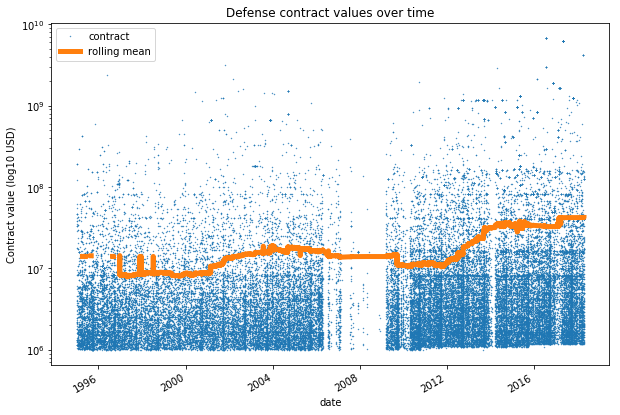

In [108]:
plt.figure(figsize=(10,7))
data2.amount.plot(marker='.', markersize=.8, linestyle='', logy=True, label='contract')
data2.dropna(axis='rows',how='any').amount.rolling(5000,).mean().plot(logy=True, label='rolling mean', linewidth=5)
plt.ylabel('Contract value (log10 USD)')
plt.title('Defense contract values over time')
plt.legend()
plt.show()

It's pretty obvious that there is some missing data from 2006-2010, and looking at my error logs, it seems that there is some scraping issue at play here - some formatting changed so I need to make the system robust to these changes. 

__Until then__ I'll just use data after 2011:

In [89]:
data_censured = data['2011':'2018']

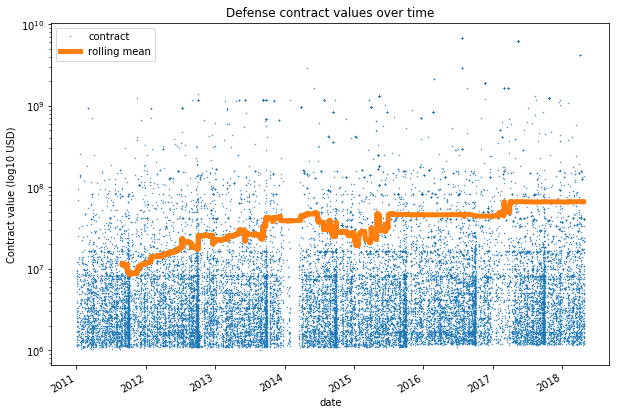

In [114]:
plt.figure(figsize=(10,7))
d2 = data_censured[data_censured.amount > 1e6]
d2.amount.plot(marker='.', markersize=.8, linestyle='', logy=True, label='contract')
d2.dropna(axis='rows',how='any').amount.rolling(2000,).mean().plot(logy=True, label='rolling mean', linewidth=5)
plt.ylabel('Contract value (log10 USD)')
plt.title('Defense contract values over time')
plt.legend()
plt.show()

## Periodicity in the award frequency
You can see by eye that contracts seem to be awarded later in the year, probably due to the end of the fiscal year in October(?). Let's explore this a bit:

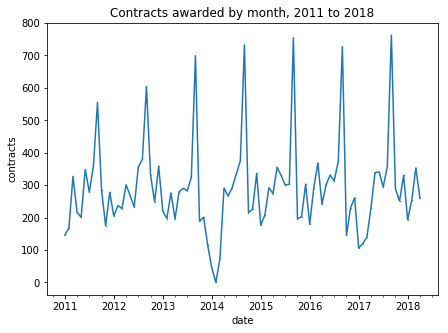

In [154]:
plt.figure(figsize=(7,5))
d2 = data_censured[data_censured.amount > 1e6]
# d2.amount.resample('m').median().plot(marker='.', markersize=.8, linestyle='-', logy=True, label='contract')
d2.amount.resample('m').count().plot(marker='.', markersize=.8, linestyle='-', logy=False, label='contract')
# d2.dropna(axis='rows',how='any').amount.rolling(2000,).mean().plot(logy=True, label='rolling mean', linewidth=5)
plt.ylabel('contracts')
plt.title('Contracts awarded by month, 2011 to 2018')

plt.show()

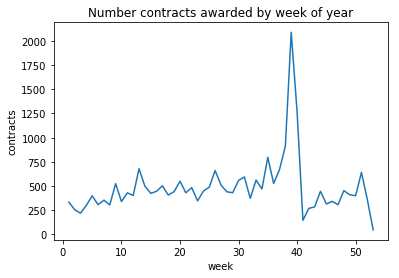

In [155]:
week_group = d2.amount.groupby(d2.index.week)
week_group.count().plot(secondary_y=False)
plt.title('Number contracts awarded by week of year')
plt.ylabel('contracts')
plt.xlabel('week')
plt.show()

## interactive plotting
Let's quickly plot the big contract values over time using plotly. You should be able to interact with this and see which city recieved the contract.

In [171]:
big_contracts = d2[d2.amount > .5e9]
data = go.Scatter(
    name='Measurement',
    x=big_contracts.index,
    y=big_contracts.amount,
    text=big_contracts.city + ', ' + big_contracts.state,
    mode = 'markers')
layout= go.Layout(
    title= 'Big contracts interactive plot',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Award date',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Contract value (USD)',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=[data], layout=layout)
py.iplot(fig)

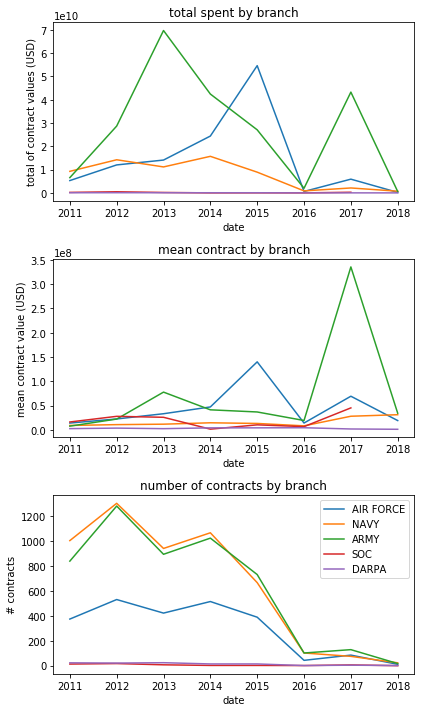

In [90]:
f, axes = plt.subplots(3,1, figsize=(6,10))
for branch in ['AIR FORCE', 'NAVY', 'ARMY', 'U.S. SPECIAL OPERATIONS COMMAND',
               'DEFENSE ADVANCED RESEARCH PROJECTS AGENCY',]:
    mask = data_censured.branch == branch
    if branch == 'DEFENSE ADVANCED RESEARCH PROJECTS AGENCY':
        branch = 'DARPA'
    elif branch == 'U.S. SPECIAL OPERATIONS COMMAND':
        branch = 'SOC'
    
    resampled = data_censured[mask].amount.resample('y')
    
    resampled.sum().plot(label=branch, ax=axes[0])
    resampled.mean().plot(label=branch, ax=axes[1])
    mask.resample('y').sum().plot(label=branch, ax= axes[2])
    
    titles = ['total spent by branch', 'mean contract by branch', 'number of contracts by branch']
    y_labels = ['total of contract values (USD)', 'mean contract value (USD)', '# contracts']
    for t, a, y_ in zip(titles, axes, y_labels):
        a.set_title(t)
        a.set_ylabel(y_)
    
    plt.legend()
    plt.tight_layout()